# Turkish Lira Project

**Author**: *Federico Cioschi*

## Preliminary Operations

### Mount Google Drive
It will be useful later to save experiments results.

*You may also leave the following cell unexecuted if you are not interested in saving results.*

In [ ]:
from google.colab import drive
GDRIVE_MOUNT_POINT = '/content/drive/'
drive.mount(GDRIVE_MOUNT_POINT)
GDRIVE_PROJECT_DIR = GDRIVE_MOUNT_POINT + 'My Drive/amd_project/'

Mounted at /content/drive/


### Download the dataset from Kaggle

In [ ]:
from google.colab import files
print("Please upload the 'kaggle.json' file with your Kaggle credentials:\n")
files.upload()

# Move `kaggle.json` to the right place
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dowload dataset from Kaggle
!mkdir data
!kaggle datasets download baltacifatih/turkish-lira-banknote-dataset -p data --unzip

100% 3.50G/3.50G [01:02<00:00, 42.8MB/s]



### Import libraries

In [ ]:
import os
import tensorflow as tf
import math
import pickle
import time

from matplotlib import pyplot as plt
from datetime import datetime

print(tf.__version__)

2.4.1


### Global variables definition

In [ ]:
DATA_DIR = "data/"
RESIZED_WIDTH  = 64
RESIZED_HEIGHT = 64
BATCH_SIZE = 100
EPOCHS = 20
VALIDATION_SPLIT = .2
DATASET_SIZE = 6000
STEPS_PER_EPOCH = DATASET_SIZE * (1 - VALIDATION_SPLIT) // BATCH_SIZE
SEED=42
OPTIMIZATIONS = ['basic', 'batch_normalization', 'batch_normalization_&_lr_decay']
AUTOTUNE = tf.data.AUTOTUNE
STRATEGY = tf.distribute.MultiWorkerMirroredStrategy()

### Utility functions definition

In [ ]:
def get_timestamp():
  return datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


def pickle_dump(data, path):
  with open(path, 'wb') as f:
    pickle.dump(data, f)


def pickle_load(path):
  with open(path, 'rb') as f:
    return pickle.load(f)

def elapsed_time(start, end):
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


def save_models_and_histories_on_gdrive(models, histories):
  root_dir = GDRIVE_PROJECT_DIR + 'models_' + get_timestamp() +'/'
  os.makedirs(root_dir)
  for opt_type in OPTIMIZATIONS:
    opt_type_dir = root_dir + opt_type + '/'
    os.mkdir(opt_type_dir)
    for conv_layers in models[opt_type]:
      filename = opt_type_dir + str(conv_layers) + '.h5'
      models[opt_type][conv_layers].save(filename)

  pickle_dump(histories, root_dir + 'histories.pickle') 


def load_models_and_histories_from_gdrive(root_dir):
  if root_dir[-1]!='/':
    root_dir += '/'
  models = {opt_type: {conv_layers: None for conv_layers in range(1, 3+1)} for opt_type in OPTIMIZATIONS}
  for opt_type in OPTIMIZATIONS:
    opt_type_dir = root_dir + opt_type + '/'
    for conv_layers in models[opt_type]:
      filename = opt_type_dir + str(conv_layers) + '.h5'
      models[opt_type][conv_layers] = tf.keras.models.load_model(filename)
  
  histories = pickle_load(root_dir + 'histories.pickle')

  return models, histories

### Callbacks definition

In [ ]:
class MaxAccuracyEarlyStopping(tf.keras.callbacks.Callback):
  """Stop training if training accuracy and validation accuracy are both 1 for
  'patience' consecutive epochs."""
  def __init__(self, patience):
    self.count=0
    self.patience=patience
    super().__init__()
  
  def on_train_begin(self, logs=None):
    self.count=0
  
  def on_epoch_end(self, epoch, logs=None):
    if logs['val_accuracy']==1.0 and logs['accuracy']==1.0:
      self.count+=1
    else:
      self.count=0
    if self.count>=self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      print("Training stopped because model has maintained maximal accuracy in both training and validation for {} epochs.".format(self.patience))


class NoLearningEarlyStopping(tf.keras.callbacks.Callback):
  def __init__(self, patience):
    self.count=0
    self.patience=patience
    super().__init__()
  
  def on_train_begin(self, logs=None):
    self.count=0

  def on_epoch_end(self, epoch, logs=None):
    if logs['accuracy']<0.3:
      self.count+=1
    else:
      self.count=0
    if self.count>=self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      print("Training stopped because training accuracy has been under 0.3 for {} epochs.".format(self.patience))

In [ ]:
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule = lambda epoch: 0.01 * math.pow(0.8, epoch),
    verbose  = False
)
max_accuracy_early_stopping_callback = MaxAccuracyEarlyStopping(patience=2)
no_learning_early_stopping_callback = NoLearningEarlyStopping(patience=5)

### Model building and training

In [ ]:
def build_model(N=1, batch_normalization=False):
  "INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC"
  with STRATEGY.scope():
    M=3
    filters = 32
    model = tf.keras.Sequential()

    model.add( tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(RESIZED_HEIGHT, RESIZED_WIDTH, 3)) )

    for _ in range(M):
      for _ in range(N):
        model.add( tf.keras.layers.Conv2D(kernel_size=3, filters=filters, use_bias=(not batch_normalization), padding='same') )
        if batch_normalization:
          model.add( tf.keras.layers.BatchNormalization() )
        model.add( tf.keras.layers.Activation('relu') )
      model.add( tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding="valid") )
      filters *= 2

    model.add( tf.keras.layers.Flatten() )
    model.add( tf.keras.layers.Dense(90, use_bias=(not batch_normalization)) )
    if batch_normalization:
      model.add( tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Activation('relu') )

    model.add( tf.keras.layers.Dense(6, activation='softmax') )

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model


def fit_model(model, lr_decay=False, description=""):
  callbacks = [max_accuracy_early_stopping_callback, no_learning_early_stopping_callback]
  if lr_decay: callbacks.append(lr_decay_callback)
  if description!="": print(description)
  start = time.perf_counter()
  history = model.fit(train_ds,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=EPOCHS,
                  validation_data=validation_ds,
                  validation_steps=1,
                  callbacks=callbacks)
  elapsed_time(start, time.perf_counter())
  print('-'*80)
  return history

### Results collection and plotting

In [ ]:
def get_history_from_model(model):
  history = dict()
  for data_type in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
    history[data_type] = model.history.history[data_type]
  return history


def get_histories_from_models(models):
  histories = dict()
  for opt_type in models:
    histories[opt_type] = dict()
    for conv_layers in models[opt_type]:
      histories[opt_type][conv_layers] = get_history_from_model(models[opt_type][conv_layers])
  return histories


def plot_multiple_histories(histories, data_type, zoom=1, custom_zooms=dict()):
  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
  for row, row_name in enumerate(histories):
    for col in range(3):
      plot_single_history(history=histories[row_name][col+1],
                        data_type=data_type,
                        conv_layers=col+1,
                        opt_type=row_name,
                        ax=ax[row, col],
                        zoom=custom_zooms[(row,col)] if (row,col) in custom_zooms else zoom)


def plot_single_history(history, data_type, conv_layers, opt_type, ax=None, zoom=1):
  if ax==None:
    fig, ax = plt.subplots(figsize=(10,10)) 
  ax.set_title("Optimization: {}\nStacked ConvLayers: {}".format(opt_type, conv_layers))
  ax.set_ylabel(data_type)
  ax.set_xlabel('Epochs')
  if data_type=='accuracy':
    _range = 1-(1/zoom), 1 + 0.05/zoom
  else:
    _range = 0 - 0.05/zoom, 1/zoom
  ax.set_ylim(_range)
  ax.set_xlim(right=EPOCHS)
  training_data, validation_data = history[data_type], history['val_'+data_type]
  ax.plot(range(1, len(training_data)+1), training_data, label=data_type)
  ax.plot(range(1, len(validation_data)+1), validation_data, label='val_'+data_type)
  ax.legend()
  ax.grid()
  ax.minorticks_on()
  ax.grid(which='minor', linestyle=':')

## Training

### Training and validation datasets creation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=SEED,
  color_mode = 'rgb',
  label_mode='categorical',
  image_size=(RESIZED_HEIGHT, RESIZED_WIDTH),
  batch_size=BATCH_SIZE).repeat().cache().prefetch(buffer_size=AUTOTUNE)

Found 6000 files belonging to 6 classes.
Using 4800 files for training.


In [ ]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=SEED,
  color_mode = 'rgb',
  label_mode='categorical',
  image_size=(RESIZED_HEIGHT, RESIZED_WIDTH),
  batch_size=BATCH_SIZE).repeat().cache().prefetch(buffer_size=AUTOTUNE)

Found 6000 files belonging to 6 classes.
Using 1200 files for validation.


### Models creation and training

In [ ]:
# Basic Models
models_B = {conv_layers: build_model(N=conv_layers) for conv_layers in range(1, 3+1)}
for conv_layers in models_B:
  fit_model(models_B[conv_layers],
            description="Stacked ConvLayer(s): {}".format(conv_layers))


# Models with Batch Normalization
models_N = {conv_layers: build_model(N=conv_layers, batch_normalization=True) for conv_layers in range(1, 3+1)}
for conv_layers in models_N:
  fit_model(models_N[conv_layers],
            description="Stacked ConvLayer(s): {}\nOptimizations: Batch Normalization".format(conv_layers))


# Models with Batch Normalization and Learning Rate decay
models_N_LRD = {conv_layers: build_model(N=conv_layers, batch_normalization=True) for conv_layers in range(1, 3+1)}
for conv_layers in models_N_LRD:
  fit_model(models_N_LRD[conv_layers],
            lr_decay=True,
            description="Stacked ConvLayer(s): {}\nOptimizations: Batch Normalization and Learning Rate Decay".format(conv_layers))


models = {'basic': models_B,
          'batch_normalization': models_N,
          'batch_normalization_&_lr_decay': models_N_LRD,
         }

histories = get_histories_from_models(models)

Stacked ConvLayer(s): 1
Epoch 1/20
48/48 [==============================] - 119s 2s/step - loss: 6.3484 - accuracy: 0.1878 - val_loss: 1.7239 - val_accuracy: 0.2500
Epoch 2/20
48/48 [==============================] - 96s 2s/step - loss: 1.6804 - accuracy: 0.2916 - val_loss: 1.7026 - val_accuracy: 0.2900
Epoch 3/20
48/48 [==============================] - 91s 2s/step - loss: 1.6014 - accuracy: 0.3485 - val_loss: 1.3366 - val_accuracy: 0.5400
Epoch 4/20
48/48 [==============================] - 95s 2s/step - loss: 1.3792 - accuracy: 0.4512 - val_loss: 1.0334 - val_accuracy: 0.6300
Epoch 5/20
48/48 [==============================] - 94s 2s/step - loss: 0.9970 - accuracy: 0.6254 - val_loss: 0.5364 - val_accuracy: 0.7900
Epoch 6/20
48/48 [==============================] - 94s 2s/step - loss: 0.5410 - accuracy: 0.8045 - val_loss: 0.4774 - val_accuracy: 0.8300
Epoch 7/20
48/48 [==============================] - 91s 2s/step - loss: 0.3109 - accuracy: 0.8899 - val_loss: 0.1462 - val_accuracy: 0.

### Results saving

*If you have not mounted Google Drive on the local file system, please set `ACTION` to something different from `'save'` or `'load'`.*

In [ ]:
ACTION = 'save'

if ACTION=='load':
  load_path = input("Please enter a valid path from which models can be retrieved:")
  models, histories = load_models_and_histories_from_gdrive(load_path)
elif ACTION=='save':
  save_models_and_histories_on_gdrive(models, histories)

### Results plotting

#### General view

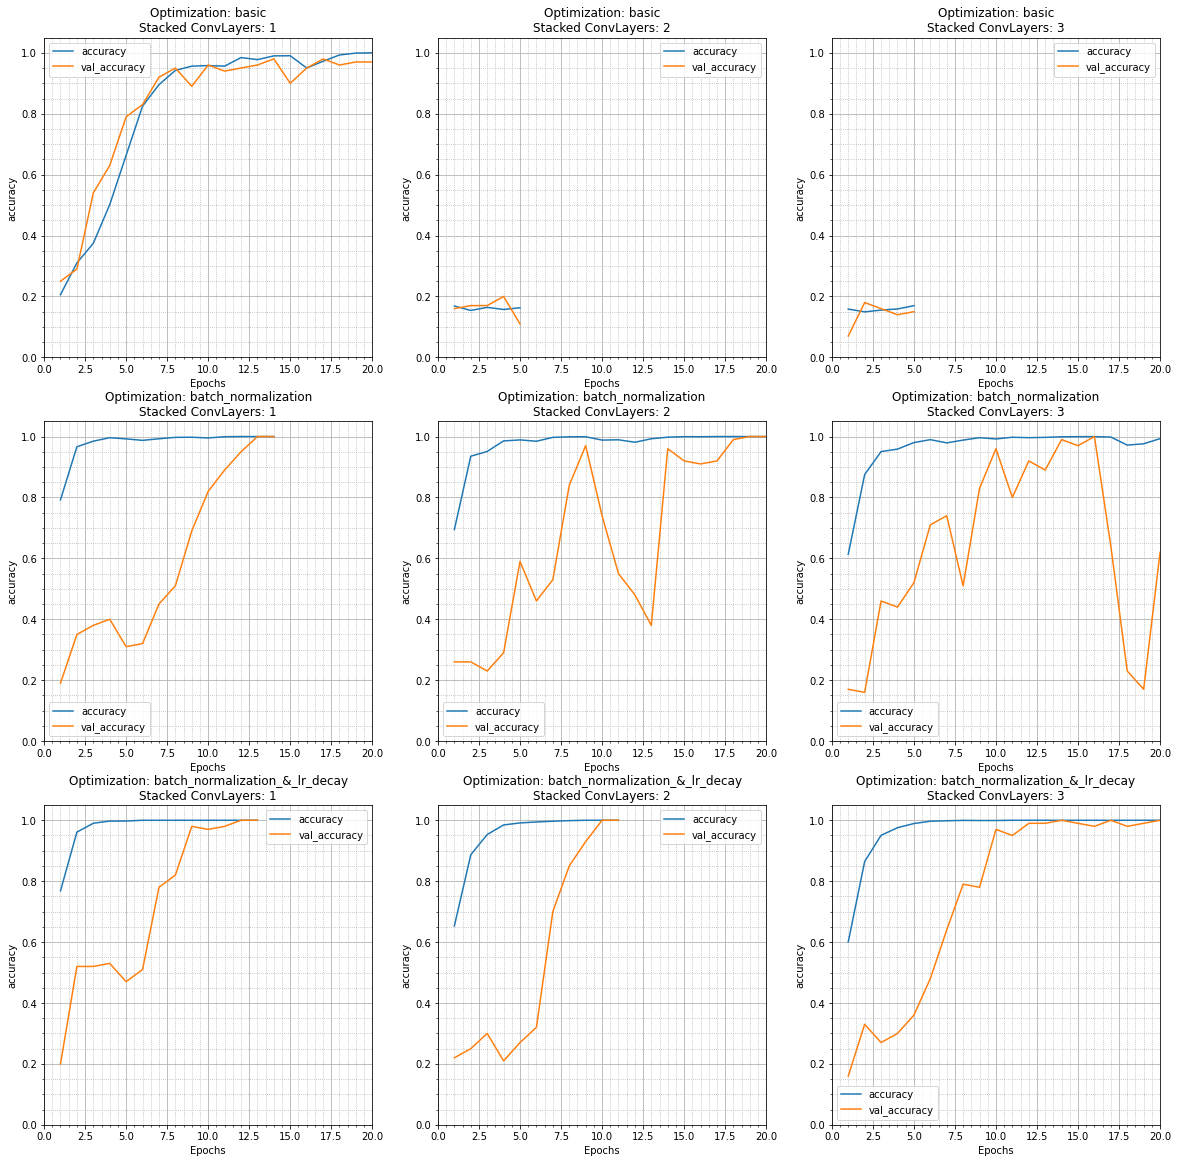

In [ ]:
plot_multiple_histories(histories, data_type='accuracy')

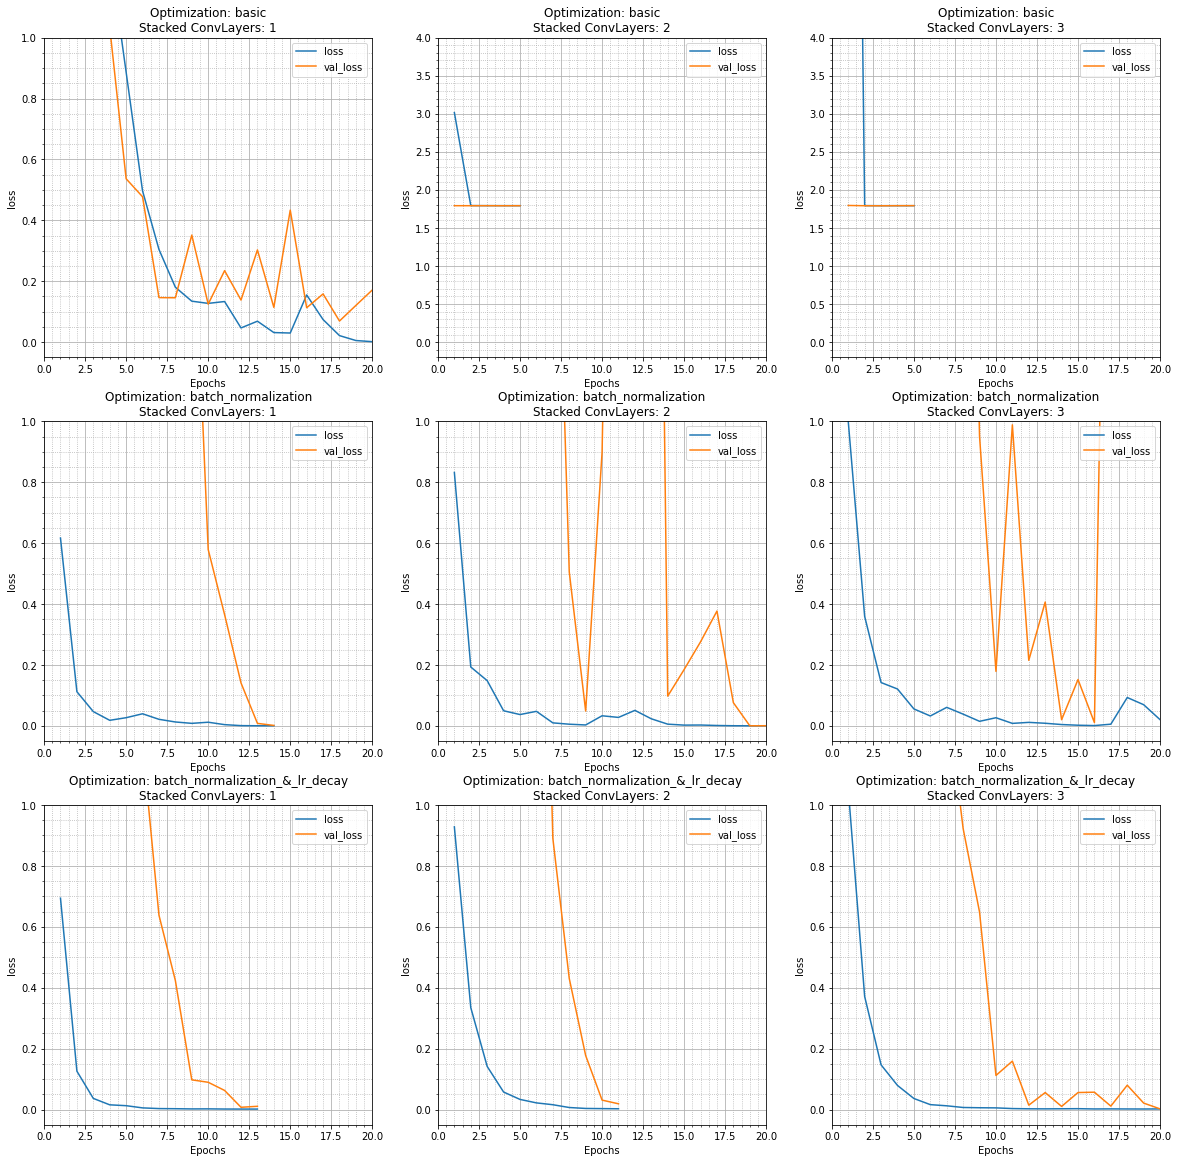

In [ ]:
plot_multiple_histories(histories, data_type='loss', custom_zooms={(0,i): 1/4 for i in range(1,3)})

#### Zoomed view

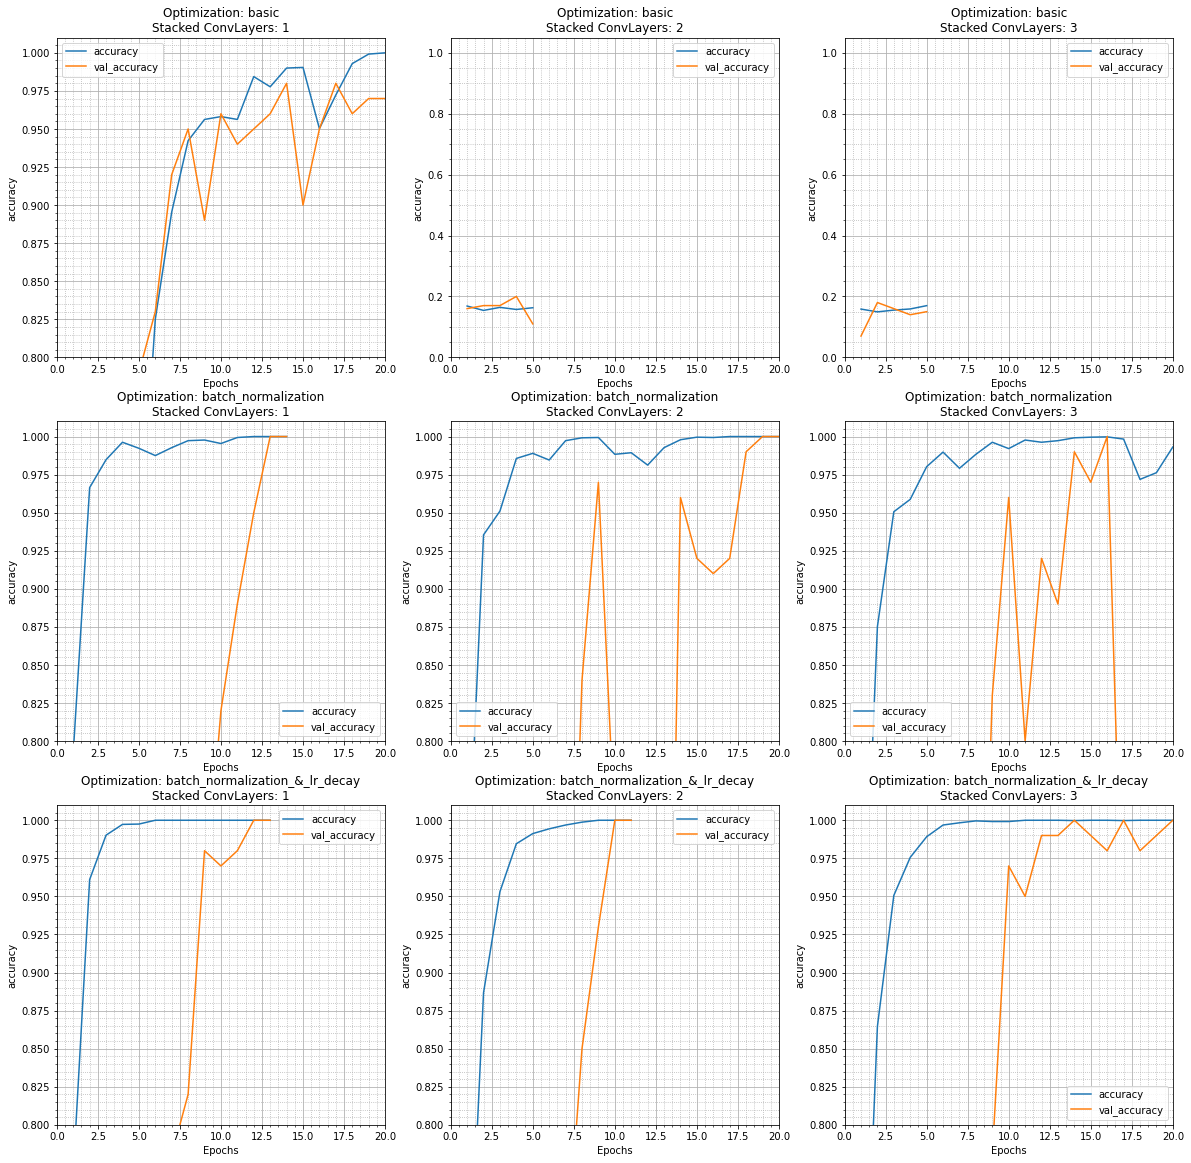

In [ ]:
plot_multiple_histories(histories, data_type='accuracy', zoom=5, custom_zooms={(0,i): 1 for i in range(1,3)})

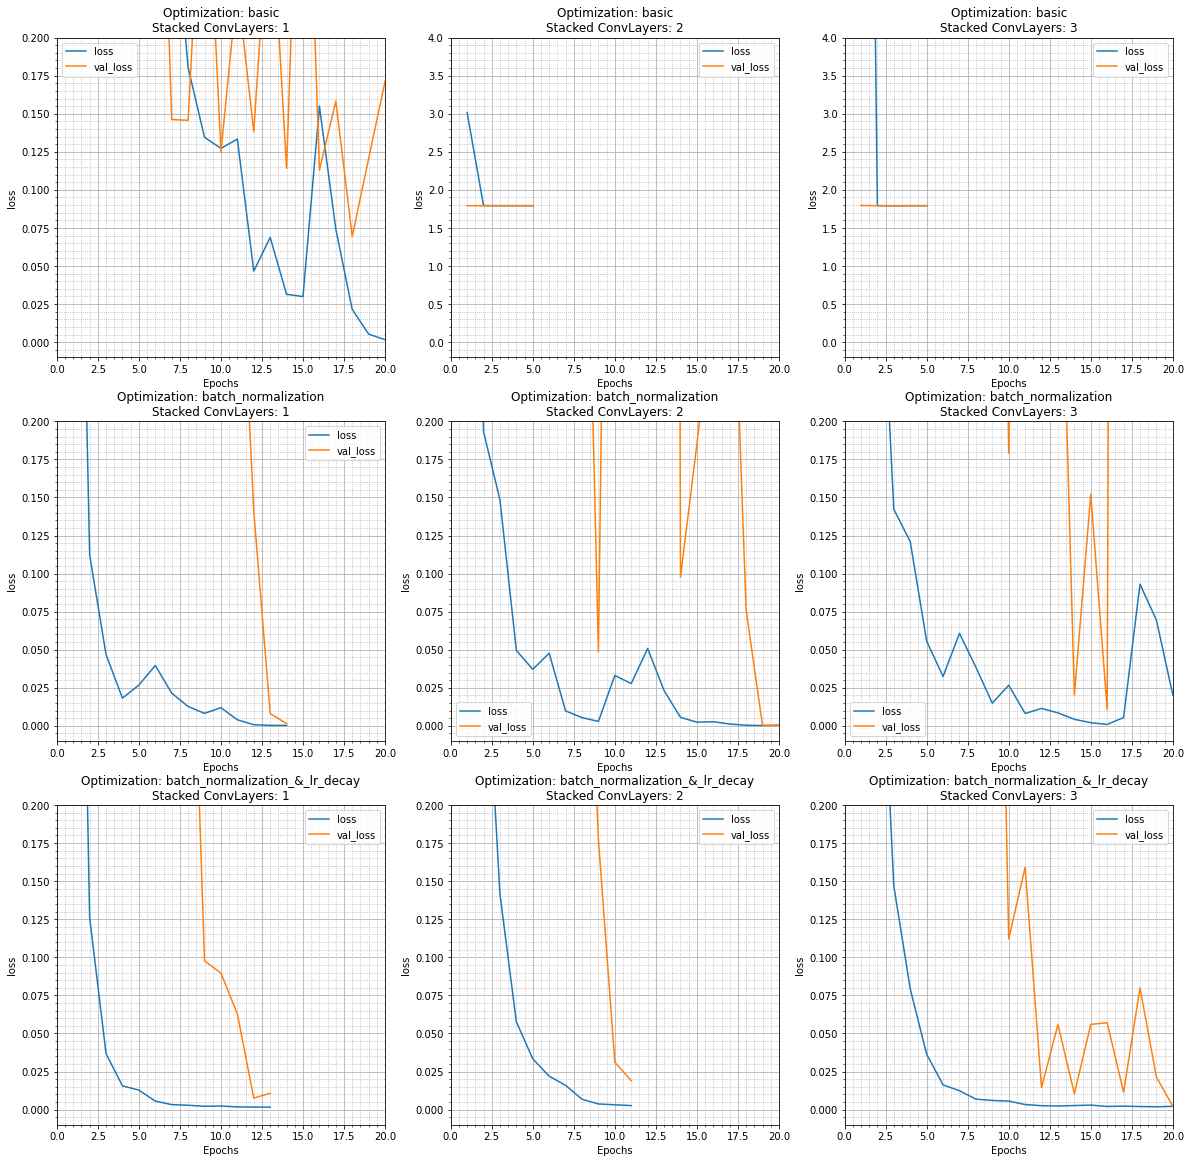

In [ ]:
plot_multiple_histories(histories, data_type='loss', zoom=5, custom_zooms={(0,i): 1/4 for i in range(1,3)})

#### Best Model
- Optimizations: Batch Normalization and Learning Rate Decay
- ConvLayers: 2

In [ ]:
models['batch_normalization_&_lr_decay'][2].summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 32)        864       
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_46 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 64, 32)        9216      
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_47 (Activation)   (None, 64, 64, 32)       

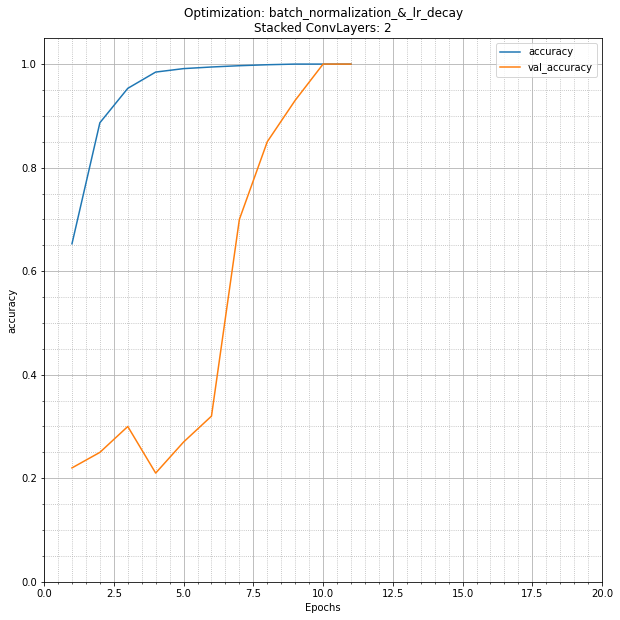

In [ ]:
plot_single_history(histories['batch_normalization_&_lr_decay'][2], data_type='accuracy', conv_layers=2, opt_type='batch_normalization_&_lr_decay')

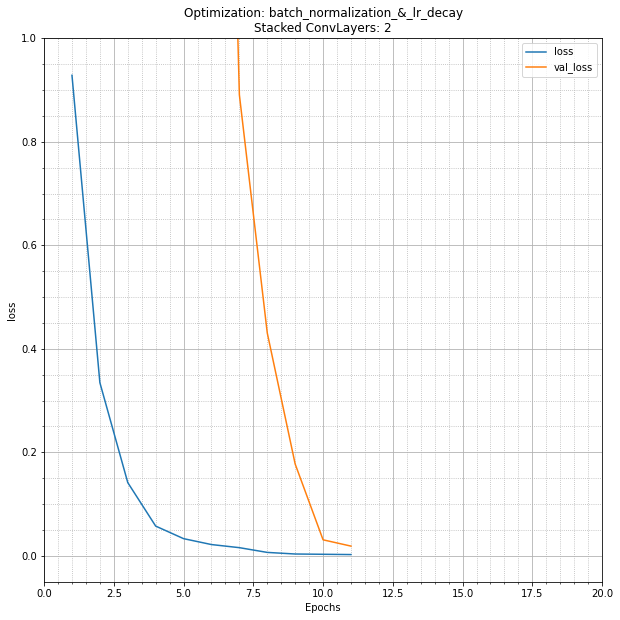

In [ ]:
plot_single_history(histories['batch_normalization_&_lr_decay'][2], data_type='loss', conv_layers=2, opt_type='batch_normalization_&_lr_decay')

In [ ]:
drive.flush_and_unmount()

## Environment hardware specs

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11361459432679584668, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4953623447354834968
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
!cat /proc/meminfo

MemTotal:       13333580 kB
MemFree:          276740 kB
MemAvailable:   10814552 kB
Buffers:           66672 kB
Cached:          5841600 kB
SwapCached:            0 kB
Active:          6274932 kB
Inactive:        6264320 kB
Active(anon):    1877796 kB
Inactive(anon):    14692 kB
Active(file):    4397136 kB
Inactive(file):  6249628 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3732 kB
Writeback:             0 kB
AnonPages:       6630636 kB
Mapped:           740172 kB
Shmem:             15648 kB
Slab:             268648 kB
SReclaimable:     216944 kB
SUnreclaim:        51704 kB
KernelStack:        5064 kB
PageTables:        21652 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666788 kB
Committed_AS:    9996044 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b